In [2]:
#pip install python-binance

In [163]:
from binance import Client
import pandas as pd
import matplotlib.pyplot as plt
import time

In [2]:
with open('access.txt') as f:
    acc = f.readlines()
api = acc[0].strip()
key = acc[1].strip()

In [3]:
client = Client(api,key)

In [22]:
def get_interval_data(currency, interval, lookback):
    interval_data = pd.DataFrame(client.get_historical_klines(currency, interval, lookback + ' minutes ago UTC'))
    interval_data = interval_data.iloc[:, :6]
    interval_data.columns = ['Time', 'Open', 'High','Low','Close', 'Volume']
    interval_data.set_index('Time', inplace=True)
    interval_data.index = pd.to_datetime(interval_data.index, unit ='ms')
    interval_data = interval_data.astype(float)
    return interval_data

In [60]:
frame = get_interval_data('DOGEUSDT', '1m', '30')

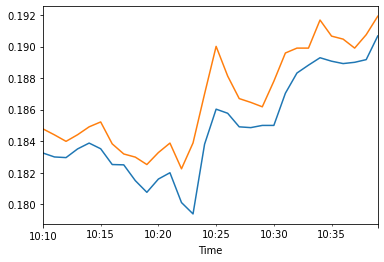

In [61]:
frame.Low.plot();
frame.High.plot();

In [171]:
class TestTrade:
    def __init__(self, symb, qnty, entered=False):
        self.symb = symb
        self.qnty = qnty
        self.entered = entered
        self.buy_orders = []
        self.sell_orders = []
    
    def get_interval_data(self, interval, lookback):
        interval_data = pd.DataFrame(client.get_historical_klines(self.symb, interval, lookback + ' minutes ago UTC'))
        interval_data = interval_data.iloc[:, :6]
        interval_data.columns = ['Time', 'Open', 'High','Low','Close', 'Volume']
        interval_data.set_index('Time', inplace=True)
        interval_data.index = pd.to_datetime(interval_data.index, unit ='ms')
        interval_data = interval_data.astype(float)
        return interval_data
        
    def buy_order(self):
        while True:
            frame = self.get_interval_data('1m', '100')
            change = (frame.Open.pct_change() +1).cumprod() - 1
            if change[-1] < -0.005:
                
                order = client.create_order(symbol=self.symb,side='BUY', type='MARKET', quantity=self.qnty)
                print('BUY order executed')
                self.entered = True
                self.buy_orders.append(order)
                break
    
    def sell_order(self):
        time_buy = pd.to_datetime(self.buy_orders[-1]['transactTime'],unit='ms')
        while True:
            frame = self.get_interval_data('1m', '100')
            since_buy = frame.loc[frame.index > time_buy]
            if len(since_buy) > 0:
                change = (since_buy.Open.pct_change() +1).cumprod() -1
                if change[-1] > 0.005:
                    order = client.create_order(symbol=self.symb,side='SELL', type='MARKET', quantity=self.qnty)
                    print('SELL order executed')
                    self.entered = False
                    self.sell_orders.append(order)
                    break
                
    def trade(self):
   
        while len(self.buy_orders) < 3:
            if not self.entered:
                self.buy_order()
            if self.entered:
                self.sell_order()
                time.sleep(10)

In [178]:
test_trade = TestTrade('DOGEUSDT', 100)
#test_trade.trade()

In [174]:
b = [float(i['cummulativeQuoteQty']) for i in test_trade.buy_orders]

In [175]:
b

[23.301]

In [176]:
s = [float(i['cummulativeQuoteQty']) for i in test_trade.sell_orders]

In [177]:
s

[]